In [ ]:
import kagglehub
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import time
from collections import defaultdict

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms, models
from torchvision.transforms import functional as Func


# Loading Data

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [03:53<00:00, 23.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
df_meta = pd.read_csv('/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv')
df_meta.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


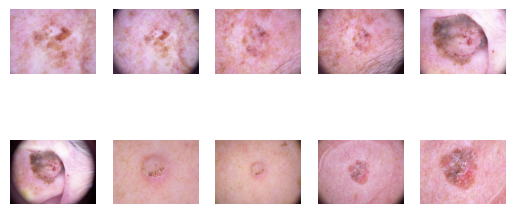

In [ ]:
def get_image_path(image_id):
  if int(image_id[7:]) < 29306: #HAM10000 part 1
    image_path = f"/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1/{image_id}.jpg"
  else: #HAM10000 part 2
    image_path = f"/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2/{image_id}.jpg"
  return image_path


for index, row in df_meta.iterrows():
  img_path = get_image_path(row["image_id"])
  image = cv2.imread(img_path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert BGR to RGB
  plt.subplot(3, 5, index+1)
  plt.axis('off')
  plt.imshow(image)

  if index == 9:
    break


# Data Analysis

In [ ]:
#Null Value Handling
df_meta.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [ ]:
#Unknown Value Handling
unknown_counts = df_meta.apply(lambda x: (x == 'unknown').sum())

print(unknown_counts)

lesion_id         0
image_id          0
dx                0
dx_type           0
age               0
sex              57
localization    234
dtype: int64


In [ ]:
#Checking for duplicates
duplicates = df_meta[df_meta[['lesion_id','dx','dx_type','age','sex','localization']].duplicated()].index
lesion_duplicates = df_meta[df_meta['lesion_id'].duplicated()].index
set_1 = set(duplicates)
set_2 = set(lesion_duplicates)

#We want to check if we want to remove duplications in lesion_id, or duplications in all the columns
diff = set_2 - set_1
print(f"Indices with same lesion_id but different values in other columns: {diff}")
df_meta.iloc[list(diff)[0]]

Indices with same lesion_id but different values in other columns: {2008, 2014}


,2008
lesion_id,HAM_0001726
image_id,ISIC_0024700
dx,mel
dx_type,histo
age,35.0
sex,female
localization,trunk


In [ ]:
#Same lesion_id but different values in other columns
dup = df_meta[df_meta['lesion_id'] == "HAM_0001726"]
dup

,lesion_id,image_id,dx,dx_type,age,sex,localization
1247,HAM_0001726,ISIC_0029281,mel,histo,35.0,female,back
1248,HAM_0001726,ISIC_0024367,mel,histo,35.0,female,back
2008,HAM_0001726,ISIC_0024700,mel,histo,35.0,female,trunk


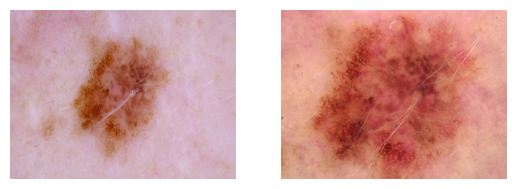

In [ ]:
img_path = get_image_path("ISIC_0029281")
image = cv2.imread(img_path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

img_path = get_image_path("ISIC_0024700")
image2 = cv2.imread(img_path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

plt.subplot(1, 2, 1)#
plt.axis('off')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image2)

There are some datas which have the same lesion_id, but different image & metadata; so, we will consider them as different data points and remove datas which has duplicated values in all columns

# Data Processing

**Data Cleaning**

In [ ]:
#drop null and unknown rows
def clean_data(df):
  # drop rows with unknown values for sex, localization, and age
  df = df.dropna(subset=['age'])
  df = df[(df['localization'] != 'unknown') & (df['sex'] != 'unknown')]

  #drop duplicates
  df = df.drop_duplicates(subset=df.columns.difference(['image_id']))

  # drop irrelevant metadata columns
  df = df.drop(columns=['dx_type', 'lesion_id'])

  #Create one hot encoding on meta data
  df = pd.get_dummies(df, columns=['sex','localization'], drop_first=False, dtype=int)

  return df
df_meta = clean_data(df_meta)


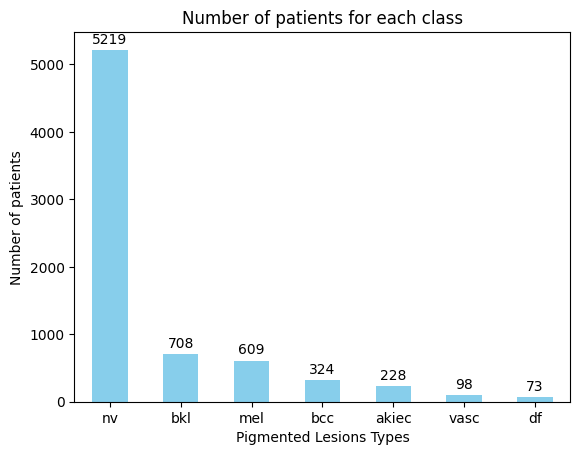

In [ ]:
dx_counts = df_meta['dx'].value_counts()
ax = dx_counts.plot(kind='bar', color='skyblue')

plt.title("Number of patients for each class")
plt.xlabel("Pigmented Lesions Types")
plt.ylabel("Number of patients")
plt.xticks(rotation=0)

for i, count in enumerate(dx_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

The graph shows a big imbalance in number of each label

In [ ]:
'''
Melanocytic nevi - Benign

Melanoma - Malignant

Benign keratosis-like lesions - Benign

Basal cell carcinoma - Malignant

Actinic keratoses - Benign

Vascular lesions - Benign

Dermatofibroma - Benign
'''
# Get count of benign conditions
benign = df_meta[df_meta['dx'].isin(['nv', 'bkl', 'akiec', 'vasc', 'df'])]['dx'].value_counts()
print("\nTotal benign cases:", benign.sum())

# Get count of malignant conditions
malignant = df_meta[df_meta['dx'].isin(['mel', 'bcc'])]['dx'].value_counts()
print("\nTotal malignant cases:", malignant.sum())



Total benign cases: 6326

Total malignant cases: 933


Changing label to Benign and Malignant does not solve data imbalance; so, we will work with multiclass classification.


As Image in HAM10000 is fairly preprocessed, we will do minor adjustments to the image which are resizing and center cropping.

In [ ]:
def process_image(image, width, height, validation):
    #Step 1: Resizing image so that short side is 1.25* larger than input size
    new_height = 1.25* height
    old_height, old_width = image.shape[:2]
    aspect_ratio = old_width/old_height
    new_width = new_height*aspect_ratio

    image = cv2.resize(image,(int(new_width), int(new_height)))

    #Step2: Random Square Center Crop with size between [0.8,1] of the resized image
    if validation == False:
      relative_size = np.random.uniform(0.8, 1)
    else:
      relative_size = 0.9
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
        transforms.CenterCrop((int(new_height * relative_size), int(new_width * relative_size)))
    ])
    cropped = transform(image)


    #Step3: Resize cropped image to the desired input size
    resize = transforms.Resize((height, width))
    return resize(cropped)
def get_image(image_id, for_CNN=True, width=24, height=18,  validation = False):
    #A function for getting image from our meta data
    image_path = get_image_path(image_id)
    try:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert BGR to RGB
        #For CNN, we preprocess and Normalize
        if for_CNN == True:
          image = process_image(image, width, height, validation)
          transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          image = transform(image)
        #For Decision Tree and Logistic Regression, we resize and flatten
        else:
          image = cv2.resize(image,(width,height))
          image = image.flatten()
        return image
    except FileNotFoundError:
        print(f"Image {image_id} not found.")
        return None

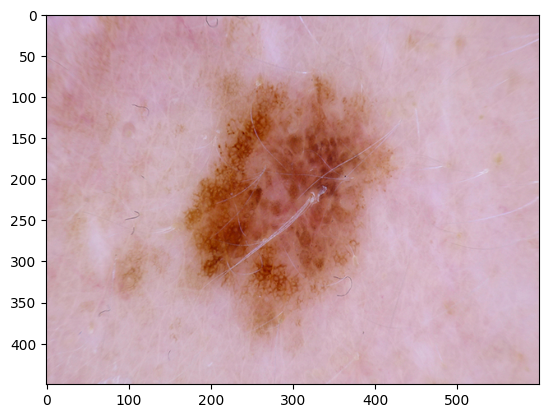

In [ ]:
path = get_image_path("ISIC_0029281")
unprocessed = cv2.imread(path, cv2.IMREAD_COLOR) #OpenCV reads color images in BGR
unprocessed = cv2.cvtColor(unprocessed, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

plt.imshow(unprocessed)

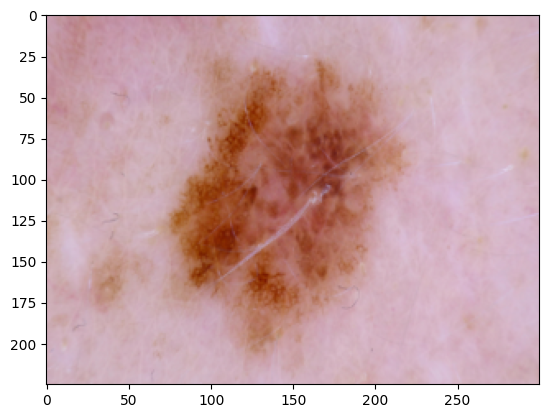

In [ ]:
sample = get_image("ISIC_0029281", True, 300, 225, False)
sample = np.transpose(sample, [1,2,0])
# normalize pixel intensity values to [0, 1]
sample = sample / 2 + 0.5
plt.imshow(sample)

**Data Augmentation**

In [ ]:
def augment_image(image):
    #Random Horizontal Flips
    copies = [image]
    p_value = random.random()
    if p_value > 0.5:
      transform = transforms.RandomHorizontalFlip(p=1.0)
      flipped_image = transform(image)
      copies.append(flipped_image)

    #Random Rotation
    p_values = np.random.choice([0, 1], size=3, p=[0.5, 0.5])
    for i in range(len(p_values)):
      if p_values[i] == 1:
        if i == 0:
          rotated = Func.rotate(image, angle=90)
        elif i == 1:
          rotated = Func.rotate(image, angle=180)
        else:
          rotated = Func.rotate(image, angle=270)
        copies.append(rotated)

    #Random Brightness, Saturation, & Contrast
    brightness_factor = random.uniform(0.9, 1.1)
    saturation_factor = random.uniform(0.9, 1.1)
    contrast_factor = random.uniform(0.9, 1.1)

    #Unnormalized image first
    unnormed_image = image / 2 + 0.5

    transform = transforms.Compose([
        transforms.ColorJitter(brightness=brightness_factor,
                                saturation=saturation_factor,
                                contrast=contrast_factor),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])
    copies.append(transform(unnormed_image))
    return copies




**Train-Validation-Test Split**

In [ ]:
# Train-Validation-Test split (60-20-20)
X = df_meta.drop(columns=['dx'])
Y = df_meta['dx']

# First split for training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Second split to divide temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Primary Model

In [ ]:
def load_data(batch_size, width=200, height=150):
    def create_dataset(X,y, validation):
      #Get images with preprocessing & Normalization applied
      X_img = X['image_id'].apply(get_image, args=(True, width, height, validation))
      X_img = torch.tensor(np.stack(X_img.values), dtype=torch.float32)

      #Turn label into one hot encoding
      y_one_hot = torch.tensor((pd.get_dummies(y, drop_first=False)).to_numpy(), dtype=torch.float32)

      #Get metadata
      X_meta = torch.tensor(X.drop(columns=['image_id']).values.tolist(), dtype=torch.float32)

      #Group the three together
      dataset = TensorDataset(X_img, X_meta, y_one_hot)
      return dataset
    train_data = create_dataset(X_train, y_train, False)
    val_data = create_dataset(X_val, y_val, True)
    test_data = create_dataset(X_test, y_test, True)

    train_indices = list(range(len(train_data)))
    val_indices = list(range(len(val_data)))
    test_indices = list(range(len(test_data)))

    #Generating batches
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=1, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=1, sampler=test_sampler)
    return (train_loader, val_loader, test_loader)
def augment_loader(batch_size, width=200, height=150):
    X_train_img = X_train['image_id'].apply(get_image, args=(True, width, height, False))

    temp = pd.get_dummies(y_train, drop_first=False)
    mapping = temp.columns.tolist()
    y_train_one_hot = torch.tensor((temp).to_numpy(), dtype=torch.float32)
    X_train_meta = torch.tensor(X_train.drop(columns=['image_id']).values.tolist(), dtype=torch.float32)

    position_of_akiec = mapping.index('akiec')
    position_of_df = mapping.index('df')
    position_of_vasc = mapping.index('vasc')

    new_image = []
    new_y = []
    new_meta = []
    for i,img in enumerate(X_train_img):
      label = torch.argmax(y_train_one_hot[i]).item()

      #If label is not the minority
      if not (label in [position_of_akiec, position_of_df, position_of_vasc]):
        #Don't do Augmentation
        new_image.append(img)
        new_y.append(y_train_one_hot[i])
        new_meta.append(X_train_meta[i])
        continue
      #Do Augmentation only in the minority class
      augmented = augment_image(img)
      for j in range(len(augmented)):
        new_image.append(augmented[j])
        new_y.append(y_train_one_hot[i])
        new_meta.append(X_train_meta[i])
    new_image = torch.stack(new_image)
    new_y = torch.stack(new_y)
    new_meta = torch.stack(new_meta)
    dataset = TensorDataset(new_image, new_meta, new_y)

    indices = list(range(len(dataset)))
    augmented_sampler = SubsetRandomSampler(indices)
    augmented_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, sampler=augmented_sampler)
    return augmented_loader
def inspect_loader(loader, loader_name):
    total_samples = 0
    class_counts = defaultdict(int)

    for images, metadata, labels in loader:
        batch_size = images.size(0)
        total_samples += batch_size
        for label in labels:
            actual = torch.argmax(label).item()
            class_counts[actual] += 1

    print(f"{loader_name}:")
    print(f"  Total samples: {total_samples}")
    print(f"  Class distribution: {dict(class_counts)}")
    return total_samples, dict(class_counts)

In [ ]:
#Testing augment_loader function
augmented_train = augment_loader(8)
for image, meta, label in augmented_train:
  print(f"image = {image.shape}")
  print(f"meta = {meta.shape}")
  print(f"label = {label.shape}")
  break
print(f"Number of Batches = {len(augmented_train)}")

del augmented_train

image = torch.Size([8, 3, 150, 200])
meta = torch.Size([8, 17])
label = torch.Size([8, 7])
Number of Batches = 740


In [ ]:
#Testing our loader
train_loader = load_data(16)[0]
for image, meta, label in train_loader:
  print(f"image = {image.shape}")
  print(f"meta = {meta.shape}")
  print(f"label = {label.shape}")
  break
total_samples, class_counts = inspect_loader(train_loader, "Train Loader")
del train_loader

image = torch.Size([16, 3, 150, 200])
meta = torch.Size([16, 17])
label = torch.Size([16, 7])
Train Loader:
  Total samples: 5081
  Class distribution: {0: 160, 4: 428, 5: 3675, 1: 224, 6: 62, 2: 479, 3: 53}


In [ ]:
sorted_counts = dict(sorted(class_counts.items()))
print(sorted_counts)
weights = np.full(7,total_samples)
counts = np.array(list(sorted_counts.values()))
print(counts)
print(weights/counts)

{0: 160, 1: 224, 2: 479, 3: 53, 4: 428, 5: 3675, 6: 62}
[ 160  224  479   53  428 3675   62]
[31.75625    22.68303571 10.60751566 95.86792453 11.87149533  1.38258503
 81.9516129 ]


In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
def evaluateCNN(net, loader, criterion, include_meta = False):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    all_true = []
    all_pred = []
    for i, data in enumerate(loader, 0):
        inputs, meta, labels = data
        if include_meta == False:
          outputs = net(inputs)
        else:
          outputs = net(inputs, meta)
        loss = criterion(outputs, labels)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
        all_true.append(labels)
        all_pred.append(predicted)
        corr = predicted != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)

    all_true = torch.cat(all_true)
    all_pred = torch.cat(all_pred)

    # Convert to numpy for f1_score calculation
    all_true = all_true.numpy()
    all_pred = all_pred.numpy()

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss, f1_score(all_true,all_pred,average='weighted'),  recall_score(all_true,all_pred,average='weighted')
def plot_training_curve(path, f1):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.
    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.plot(range(1,n+1), f1, label="Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend(loc="best")
    plt.show()


def train(net, batch_size = 64, learning_rate=0.01, num_epochs=30, width=200, height=150, apply_aug = True, include_meta = False):

    train_loader, val_loader, test_loader = load_data(batch_size, width, height)

    #Weights calculation for weighted cross entropy
    total_samples, class_counts = inspect_loader(train_loader, "Train Loader")
    sorted_counts = dict(sorted(class_counts.items()))
    weights = np.full(7,total_samples)
    counts = np.array(list(sorted_counts.values()))
    weights = weights/counts
    weights = torch.tensor(weights, dtype=torch.float)
    print(f"Weights Used: {weights}")

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    f1 = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
      total_train_loss = 0.0
      total_train_err = 0.0
      total_epoch = 0
      if apply_aug == True:
        train_loader = augment_loader(batch_size, width, height) #Apply Augmentation every epoch
      for i, data in enumerate(train_loader, 0):
        inputs, meta, labels = data
        labels = torch.argmax(labels,dim=1)

        optimizer.zero_grad()
        if include_meta == False:
          outputs = net(inputs)
        else:
          outputs = net(inputs, meta)

        loss = criterion(outputs, labels)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

        optimizer.step()

        predicted = torch.argmax(outputs, dim=1)


        corr = predicted != labels
        total_train_err += int(corr.sum())
        total_train_loss += loss.item()
        total_epoch += len(labels)
      train_err[epoch] = float(total_train_err) / total_epoch
      train_loss[epoch] = float(total_train_loss) / (i+1)
      val_err[epoch], val_loss[epoch], f1[epoch], sensitivity = evaluateCNN(net, val_loader, criterion, include_meta = include_meta)

      print(("Epoch {}: Train err: {}, Train loss: {} |"+
            "Validation err: {}, Validation loss: {}").format(
                epoch + 1,
                train_err[epoch],
                train_loss[epoch],
                val_err[epoch],
                val_loss[epoch]))
      model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    return f1


In [ ]:
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.name = "hybrid"

        # CNN for image processing
        resnet = models.resnet18(pretrained=True)

        self.cnn = nn.Sequential(*list(resnet.children())[:-1])

        # freeze
        for param in self.cnn.parameters():
          param.requires_grad = False

        # ANN for metadata processing
        self.ann = nn.Sequential(
            nn.Linear(17, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32)
        )

        # Combine CNN and ANN outputs and pass through final layers
        self.fc = nn.Sequential(
            nn.Linear(512+32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 7)
        )

    def forward(self, image, metadata):
        cnn_features = self.cnn(image)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)

        ann_features = self.ann(metadata)

        combined_features = torch.cat((cnn_features, ann_features), dim=1)

        output = self.fc(combined_features)
        return output

In [ ]:
net = HybridModel()
summary(net.ann, input_size=(17,),device = 'cpu')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,152
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [ ]:
summary(net.fc, input_size=(512+32,),device = 'cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          69,760
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                    [-1, 7]             903
Total params: 70,663
Trainable params: 70,663
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.27
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [ ]:
#def train(net, batch_size = 64, learning_rate=0.01, num_epochs=30, width=200, height=150, apply_aug = True, include_meta = False):


f1 = train(net,batch_size = 32,learning_rate=0.001,num_epochs = 10, width=224, height = 224, apply_aug = False, include_meta = True) #Specify input width & height in train function and ur good to go!

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Loader:
  Total samples: 5081
  Class distribution: {5: 3675, 4: 428, 6: 62, 0: 160, 2: 479, 3: 53, 1: 224}
Weights Used: tensor([31.7563, 22.6830, 10.6075, 95.8679, 11.8715,  1.3826, 81.9516])
Epoch 1: Train err: 0.44459752017319426, Train loss: 1.7883010982717358 |Validation err: 0.4426078971533517, Validation loss: 11.266215089389256
Epoch 2: Train err: 0.408777799645739, Train loss: 1.561436412469396 |Validation err: 0.3379247015610652, Validation loss: 9.968762642996651
Epoch 3: Train err: 0.41133635111198585, Train loss: 1.4171772051907185 |Validation err: 0.46189164370982555, Validation loss: 9.52849589756557
Epoch 4: Train err: 0.4148789608344814, Train loss: 1.310643934978629 |Validation err: 0.3379247015610652, Validation loss: 10.774538029943194
Epoch 5: Train err: 0.38083054516827397, Train loss: 1.1857473392906428 |Validation err: 0.3810835629017447, Validation loss: 9.004597742216928
Epoch 6: Train err: 0.36469198976579414, Train loss: 1.1974427433883619 |Validation

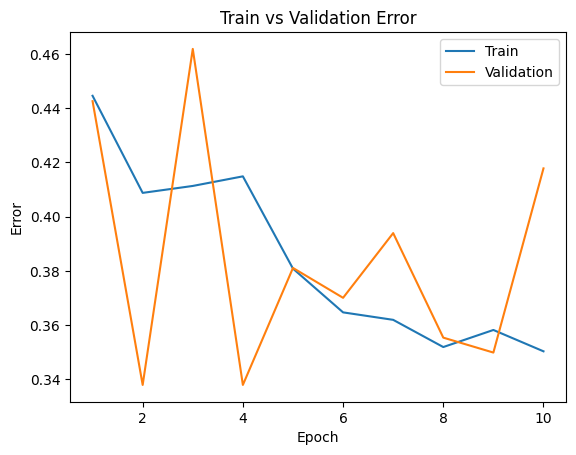

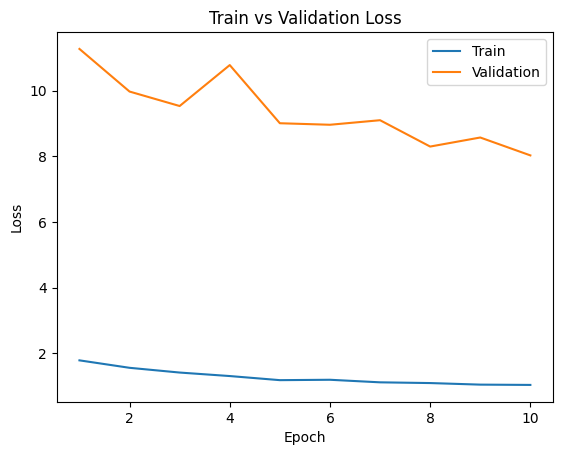

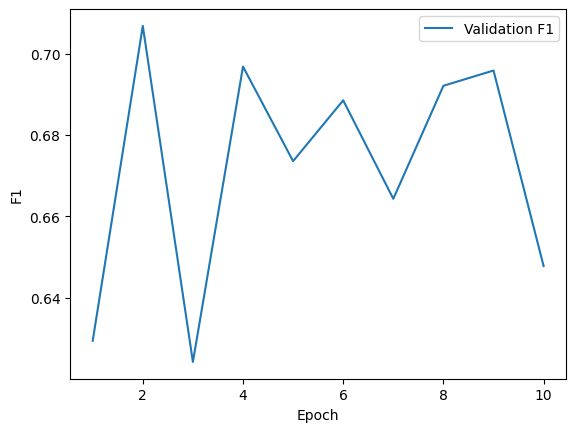

In [ ]:
model_path = get_model_name("hybrid", batch_size=32, learning_rate=0.001, epoch=9)
plot_training_curve(model_path, f1)


In [ ]:
#Saving model based on best F1
best_model = HybridModel()
model_path = get_model_name(best_model.name, batch_size=32, learning_rate=0.001, epoch=1)
state = torch.load(model_path)
best_model.load_state_dict(state)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-45-999c1786fc13>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

<All keys matched successfully>

In [ ]:
val_loader = load_data(16)[1]
error, loss, f1, sensitivity = evaluateCNN(best_model,val_loader,nn.CrossEntropyLoss(),include_meta = True)
print(f"Validation Accuracy: {1-error}, Validation F1: {f1}, Validation Sensitivity:{sensitivity}")
del val_loader

Validation Accuracy: 0.6216712580348944, Validation F1: 0.6736644041099389, Validation Sensitivity:0.6216712580348944


# Baseline Model

In [ ]:
#prepare_data function prepares data for decision tree & logistic regression
def prepare_data(X):
  #Get resized flattened image for each row
  flattened_images = X['image_id'].apply(get_image, args=(False, 24, 18, False))

  #Concatenate the flattened image to our dataframe
  image_features = pd.DataFrame(flattened_images.tolist(), index=X.index)
  X = pd.concat([X.drop(columns=['image_id']), image_features], axis=1)

  #Now we have a dataframe with large amount of columns
  X.columns = X.columns.astype(str)
  return X
formatted_X_train = prepare_data(X_train)
print(formatted_X_train.head())


       age  sex_female  sex_male  localization_abdomen  localization_acral  \
6658  45.0           1         0                     0                   0   
3414  45.0           1         0                     0                   0   
1518  80.0           1         0                     0                   0   
5382  45.0           0         1                     0                   0   
2488  85.0           0         1                     0                   0   

      localization_back  localization_chest  localization_ear  \
6658                  0                   0                 0   
3414                  0                   0                 0   
1518                  0                   0                 0   
5382                  0                   0                 0   
2488                  0                   0                 0   

      localization_face  localization_foot  ...  1286  1287  1288  1289  1290  \
6658                  0                  0  ...   238   253

In [ ]:
formatted_X_val = prepare_data(X_val)
formatted_X_test = prepare_data(X_test)

In [ ]:
#Convert label to int for training
mapping = {'nv': 0, 'mel': 1, 'bkl': 2,'bcc':3,'akiec':4,'vasc':5,'df':6}
formatted_y_train = y_train.map(mapping)
formatted_y_val = y_val.map(mapping)
formatted_y_test = y_test.map(mapping)


**Logistic Regressions**

In [ ]:
def evaluate(model, X, y):

  y_pred = model.predict(X)
  accuracy = accuracy_score(y,y_pred)
  f1 = f1_score(y,y_pred, average='weighted')
  sensitivity = recall_score(y,y_pred,average='weighted')
  return accuracy, f1, sensitivity

In [ ]:
from sklearn import preprocessing
#Standardization on X for Logistic Regression
scaler = preprocessing.StandardScaler().fit(formatted_X_train)
X_scaled_train = scaler.transform(formatted_X_train)
X_scaled_val = scaler.transform(formatted_X_val)

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.01)
model.fit(X_scaled_train, y_train)

train_accuracy, train_f1, train_sensitivity = evaluate(model, X_scaled_train, y_train)
val_accuracy, val_f1, val_sensitivity = evaluate(model, X_scaled_val, y_val)

print(f"Train Accuracy: {train_accuracy}, Train F1: {train_f1}, Train Sensitivity: {train_sensitivity}")
print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}, Validation Sensitivity: {val_sensitivity}")

Train Accuracy: 0.8667585121039165, Train F1: 0.8566629570373993, Train Sensitivity: 0.8667585121039165
Validation Accuracy: 0.7722681359044995, Validation F1: 0.7497340578877367, Validation Sensitivity: 0.7722681359044995


**Decision Tree**

In [ ]:
model = tree.DecisionTreeClassifier(random_state=0)

param_dist = {
    'max_depth': np.arange(9, 12, 1),
    'min_samples_split': np.arange(3, 8, 1)
}
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=8,
    cv=5,
    random_state=0,
)

random_search.fit(formatted_X_train, formatted_y_train)
model = random_search.best_estimator_


In [ ]:
train_accuracy, train_f1, train_sensitivity = evaluate(model, formatted_X_train, formatted_y_train)
val_accuracy, val_f1, val_sensitivity = evaluate(model, formatted_X_val, formatted_y_val)

print(f"Train Accuracy: {train_accuracy}, Train F1: {train_f1}, Train Sensitivity: {train_sensitivity}")
print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}, Validation Sensitivity: {val_sensitivity}")


Train Accuracy: 0.8960834481401299, Train F1: 0.8895076250227866, Train Sensitivity: 0.8960834481401299
Validation Accuracy: 0.721763085399449, Validation F1: 0.7077028121878258, Validation Sensitivity: 0.721763085399449


We have tried combinations of hyperparameters, and came to a conclusion that:

1. A Single Decision Tree overfits the data very easily considering the high number of features compared to the size of datas
2. Reducing complexity of the model might solve overfitting; but, the model also loses the ability to capture patterns of our datas which are very comples

Thus, A Single Decision Tree is not able to achieve good performance.

**Random Forest**

In [ ]:
model = RandomForestClassifier(
    n_estimators = 200,
    max_features = "sqrt",
    max_depth = 12,
    min_samples_split = 5,
    min_samples_leaf=5

)
model.fit(formatted_X_train, formatted_y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200)

In [ ]:
train_accuracy, train_f1, train_sensitivity = evaluate(model, formatted_X_train, formatted_y_train)
val_accuracy, val_f1, val_sensitivity = evaluate(model, formatted_X_val, formatted_y_val)

print(f"Train Accuracy: {train_accuracy}, Train F1: {train_f1}, Train Sensitivity:{train_sensitivity}")
print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}, Validation Sensitivity:{val_sensitivity}")

Train Accuracy: 0.9147805550088566, Train F1: 0.9017137993013632, Train Sensitivity:0.9147805550088566
Validation Accuracy: 0.7796143250688705, Validation F1: 0.7191549629374994, Validation Sensitivity:0.7796143250688705


The Random Forest and Single Decision Tree face the same problems.

**Simple CNN (Classification only on Images)**

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self):
      super(SimpleCNN, self).__init__()
      self.name = "Simple_CNN"
      self.conv1 = nn.Conv2d(3, 8, 3, stride = 2)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(8, 12, 3, stride = 2)
      #self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling layer
      self.fc1 = nn.Linear(9*12*12,32)
      self.fc2 = nn.Linear(32,7)
  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 9*12*12)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
base_CNN = SimpleCNN()
summary(base_CNN, input_size=(3,150,200), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 74, 99]             224
         MaxPool2d-2            [-1, 8, 37, 49]               0
            Conv2d-3           [-1, 12, 18, 24]             876
         MaxPool2d-4            [-1, 12, 9, 12]               0
            Linear-5                   [-1, 32]          41,504
            Linear-6                    [-1, 7]             231
Total params: 42,835
Trainable params: 42,835
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.34
Forward/backward pass size (MB): 0.61
Params size (MB): 0.16
Estimated Total Size (MB): 1.11
----------------------------------------------------------------


In [ ]:
#train(net, batch_size = 64, learning_rate=0.01, num_epochs=30, width=200, height=150, apply_aug = True, include_meta = False):

f1 = train(base_CNN, 32, 0.001, 20, apply_aug = False, include_meta = False)

Train Loader:
  Total samples: 5081
  Class distribution: {5: 3675, 2: 479, 1: 224, 0: 160, 3: 53, 6: 62, 4: 428}
Weights Used: tensor([31.7563, 22.6830, 10.6075, 95.8679, 11.8715,  1.3826, 81.9516])
Epoch 1: Train err: 0.5201731942530998, Train loss: 1.8477148949725073 |Validation err: 0.46097337006427913, Validation loss: 12.254990645817347
Epoch 2: Train err: 0.5250934855343437, Train loss: 1.695965976835047 |Validation err: 0.44536271808999084, Validation loss: 13.108480569294521
Epoch 3: Train err: 0.4308207045857115, Train loss: 1.5825670965062748 |Validation err: 0.4123048668503214, Validation loss: 11.239171147346497
Epoch 4: Train err: 0.3963786656170045, Train loss: 1.489539772084674 |Validation err: 0.40404040404040403, Validation loss: 11.800404678072248
Epoch 5: Train err: 0.3768943121432789, Train loss: 1.3736537976085015 |Validation err: 0.40128558310376494, Validation loss: 10.109931705679212
Epoch 6: Train err: 0.38043692186577444, Train loss: 1.2552471636976086 |Valid

array([0.5918493 , 0.61463496, 0.64408558, 0.65189568, 0.64864008,
       0.72085085, 0.68012147, 0.61045459, 0.60326526, 0.67041429,
       0.68374543, 0.70417827, 0.69853879, 0.73446521, 0.68331263,
       0.71923767, 0.62827284, 0.71586683, 0.71126953, 0.70883973])

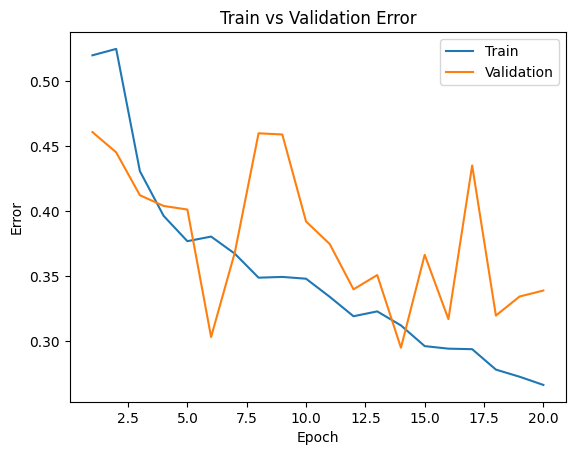

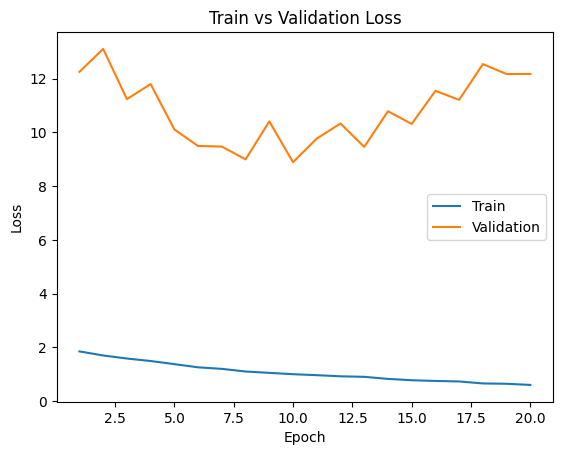

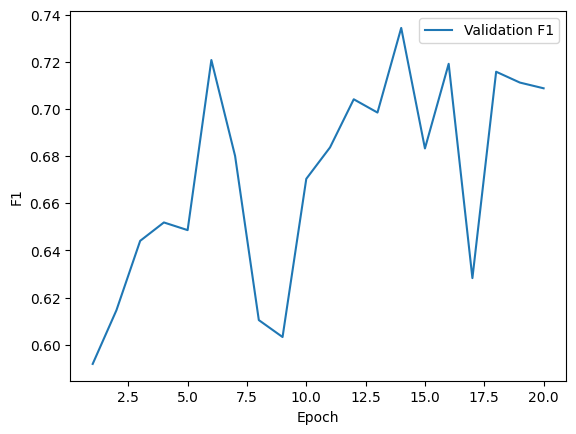

In [ ]:
# get_model_name(name, batch_size, learning_rate, epoch):

model_path = get_model_name("Simple_CNN", batch_size=32, learning_rate=0.001, epoch=19)
plot_training_curve(model_path, f1)


In [ ]:
f1

[0.5918493,
 0.61463496,
 0.64408558,
 0.65189568,
 0.64864008,
 0.72085085,
 0.68012147,
 0.61045459,
 0.60326526,
 0.67041429,
 0.68374543,
 0.70417827,
 0.69853879,
 0.73446521,
 0.68331263,
 0.71923767,
 0.62827284,
 0.71586683,
 0.71126953,
 0.70883973]

In [ ]:
best_CNN = SimpleCNN()
model_path = get_model_name(best_CNN.name, batch_size=32, learning_rate=0.001, epoch=13)
state = torch.load(model_path)
best_CNN.load_state_dict(state)

<ipython-input-70-56ef4944486c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
val_loader = load_data(16)[1]
error, loss, f1, sensitivity = evaluateCNN(best_CNN,val_loader,nn.CrossEntropyLoss(), include_meta = False)
print(f"Validation Accuracy: {1-error}, Validation F1: {f1}, Validation Sensitivity: {sensitivity}")
del val_loader

Validation Accuracy: 0.7052341597796143, Validation F1: 0.7344652112319453, Validation Sensitivity: 0.7052341597796143


In [ ]:
# def evaluate_CNN(net,loader,criterion):
#     total_loss = 0
#     total_num = 0
#     total_err = 0
#     total_num_err = 0

#     all_true = []
#     all_pred = []
#     for x,y in loader:
#       y_pred = net(x)
#       loss = criterion(y_pred,y)
#       total_loss += loss.item()
#       total_num += 1 #Average across every batch
#       total_num_err += len(y) #Average across all the labels
#       y_pred_prob = F.softmax(y_pred, dim=1)
#       #The class with maximum probability will be our prediction
#       pred = torch.argmax(y_pred_prob, dim=1)
#       true = torch.argmax(y, dim=1)
#       all_true.append(true)
#       all_pred.append(pred)
#       #Compare true label with predicted label
#       corr = pred != true
#       total_err += int(corr.sum())

#     all_true = torch.cat(all_true)
#     all_pred = torch.cat(all_pred)

#     # Convert to numpy for f1_score calculation
#     all_true = all_true.numpy()
#     all_pred = all_pred.numpy()

#     return total_loss/total_num, total_err/total_num_err, f1_score(all_true,all_pred,average='macro')
# def get_model_name(name, batch_size, learning_rate, epoch, batch):
#     """ Generate a name for the model consisting of all the hyperparameter values
#     Args:
#         config: Configuration object containing the hyperparameters
#     Returns:
#         path: A string with the hyperparameter name and value concatenated
#     """
#     path = "model_{0}_bs{1}_lr{2}_epoch{3}_batch{4}".format(name,
#                                                     batch_size,
#                                                     learning_rate,
#                                                     epoch,
#                                                     batch)
#     return path
# def plot_loss(train_loss_record, val_loss_record, start = None, end = None):
#     if start == None and end == None:
#       keys = list(train_loss_record.keys())
#       train_loss = list(train_loss_record.values())
#       val_loss = list(val_loss_record.values())
#     else:
#       keys = list(train_loss_record.keys())[start:end]
#       train_loss = list(train_loss_record.values())[start:end]
#       val_loss = list(val_loss_record.values())[start:end]

#     plt.figure(figsize=(10, 6))
#     plt.plot(keys,train_loss, label='Training Loss')
#     plt.plot(keys,val_loss, label='Validation Loss', linestyle='--')
#     plt.xlabel('Iteration (x50 batches)')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss Over Time')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
# def train(net, batch_size, learning_rate, num_epochs, train_loader=None, val_loader=None, show_loss = 1):
#     torch.manual_seed(0)
#     if train_loader == None and val_loader == None:
#       train_loader, val_loader, test_loader = load_data(batch_size)
#     #Cross Entropy Loss and Adam optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#     #Record for every 50 batch
#     train_loss_record = dict()
#     val_loss_record = dict()
#     for i in tqdm(range(num_epochs)):
#       train_loss = 0 #set train_loss = 0 at the start of each epoch
#       for j,(x,meta,y) in enumerate(train_loader):
#         y_pred = net(x)
#         loss = criterion(y_pred, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() #increment train_loss by every batch
#         if (j+1) % 50 == 0: #Compute average loss every 50 batch
#           if show_loss == 1:
#             print(f"loss at epoch:{i}, batch{j+1}: {loss.item()}")
#           avg_loss = train_loss/50
#           train_loss_record[f"({i},{j+1})"] = avg_loss #save train average loss in dictionary
#           train_loss = 0
#           val_loss = evaluate_CNN(net,val_loader,nn.CrossEntropyLoss())[0] #get validation loss from the current model
#           val_loss_record[f"({i},{j+1})"] = val_loss
#           #Save model every 50 batch
#           model_path = get_model_name(net.name, batch_size, learning_rate, i, j+1)
#           torch.save(net.state_dict(), model_path)
#     return (train_loss_record, val_loss_record)

In [ ]:
# val_loss = torch.tensor(list(val_loss_record.values()))
# min_index = torch.argmin(val_loss)
# val_key = list(val_loss_record.keys())
# best = val_key[min_index] #This is the record of the best model
# best = eval(best)

In [ ]:
# best_model = SimpleCNN()
# model_path = get_model_name(best_model.name, batch_size=32, learning_rate=0.001, epoch=best[0], batch=best[1])
# state = torch.load(model_path)
# best_model.load_state_dict(state)


In [ ]:
# val_loader = load_data(16)[1]
# loss,error,f1 = evaluate_CNN(best_model,val_loader,nn.CrossEntropyLoss())

In [ ]:
# print(f"Validation Accuracy: {1-error}, Validation F1: {f1}")